Welcome back! In this post, we will dive into Fastai's mid-level API and learn how they help us build custom pipelines & dataloaders with the help of a simple computer vision (CV) example.

The dataset we'll use is the `hello world` equivalent of CV called `MNIST`. Now, there're various ways to get this data and in fact, fastai provides it as a direct download from its `URLs.MNIST` attribute but I recently took part in a [kaggle competition](https://www.kaggle.com/competitions/digit-recognizer)[^1] that provided data in an unusual way... one that's not common enough to load via standard fastai methods. So I thought of making this post to show how that can be done! Let's go!

[^1]: [@digit-recognizer]

In [1]:
# command to print multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Load Data

In [2]:
from fastai.imports import *
from fastai.vision.all import *

::: {.callout-note}
### Kaggle setup

Kaggle provides a simple [API](https://www.kaggle.com/docs/api) to download (competition) datasets, submit results etc. Simply install it with `pip install kaggle`. You also need to download an API key fom your kaggle account. It'd download a file called `kaggle.json` which you can put it under `.kaggle` (hidden) folder under your home directory, say `(~/.kaggle/kaggle.json)`.

Once done, run `chmod 600 ~/.kaggle/kaggle.json` to fix permissions and then download the data with its API & unzip it.
:::

In [3]:
!rm -rf data && kaggle competitions download -c digit-recognizer -p data/ && unzip -q data/digit-recognizer.zip -d data/

 91%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–‹   | 14.0M/15.3M [00:01<00:00, 16.1MB/s]
100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 15.3M/15.3M [00:01<00:00, 12.5MB/s]


In [4]:
path = Path('./data')
Path.BASE_PATH = path
path.ls()

(#4) [Path('sample_submission.csv'),Path('digit-recognizer.zip'),Path('train.csv'),Path('test.csv')]

In [5]:
train = pd.read_csv(path/'train.csv')
train.shape
train.head()

(42000, 785)

label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

As you notice, the training data has `785` columns: a `label` column representing what value that is and each value in the rest of the columns representing a pixel. MNIST data, in general, consists of images of size `28x28`, equivalent to 784 pixels laid out as a plain sheet which is what we have here. Now let's unravel one to see how it looks like!

In [6]:
row = train.loc[0]
row.shape

(785,)

In [7]:
label, *pixels = row
label, len(pixels)
pixels[:20]

(1, 784)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

So the label says that the image is that of number `1`. Let's rearrange the pixels into a square of size `28x28` array.

In [8]:
arr_pixels = np.array(pixels).reshape(-1, 28)
arr_pixels[:10]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 188, 255,  94,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0, 191, 250, 253,  93,   0,   0,   0,
          0,   0],
       [  

Hmm... now we see some numbers. Let's convert that to an image!

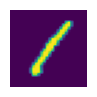

In [9]:
show_image(arr_pixels);

Cool! Notice that the image of the label is `1` as expected. :)

Now, let's convert all the data into `28x28` array.

In [10]:
# reshape the data into square images
arr = train.drop('label', axis=1).values.reshape(-1, 28, 28).astype(np.uint8)
arr.shape

(42000, 28, 28)

Let's pick a random image to check!

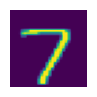

In [11]:
show_image(arr[1234]);

# peek into mid-level API

In [12]:
ImageDataLoaders.from_*?

ImageDataLoaders.from_csv
ImageDataLoaders.from_dblock
ImageDataLoaders.from_df
ImageDataLoaders.from_dsets
ImageDataLoaders.from_folder
ImageDataLoaders.from_lists
ImageDataLoaders.from_name_func
ImageDataLoaders.from_name_re
ImageDataLoaders.from_path_func
ImageDataLoaders.from_path_re

## Transforms

The image data is in the form of an array and the labels as a column in a dataframe. I couldn't find a way to load that using the standard `DataBlock` API as shown in my face mask detection [post](../face-mask-detection/facemask_detection.html) right out of the way we have it (i.e., data not being stored on disk). Perhaps one can convert each row from a `784` array to a `28x28` matrix, store it as an image in a column and then load it using one of the `ImageDataLoaders` methods as shown above. But that sounds a bit more hacky to me compared to the elegant ways `Transforms` provides.

`Transform` is a class that one can inherit from and it has 3 main methods to implement.

- `encodes` takes an item and transforms our data into the way we want (our custom transformation)
- `setups` is an optional method that sets the inner state, if there's any
- `decodes` which is an optional step too that acts as (near) opposite to `encodes`. It tries to undo the operations performed in `encodes`, if and when possible.

Here's a simple example from one of the lessons in fastai:

In [13]:
class NormalizeMean(Transform):
    def setups(self, items): self.mean = sum(items)/len(items)
    def encodes(self, x): return x-self.mean
    def decodes(self, x): return x+self.mean

Here, `setups` stores the inner state of the passed items i.e., the _mean_, `encodes` returns the data with the mean subtracted and `decodes` returns the data with the mean added (opposite of `encodes`).

In [14]:
# initialize
nm = NormalizeMean()
nm

NormalizeMean:
encodes: (object,object) -> encodes
decodes: (object,object) -> decodes

In [15]:
nm.setup([1, 2, 3, 4, 5])

In [16]:
nm.mean

3.0

In [17]:
nm(2)

-1.0

In [18]:
nm.decode(2)

5.0

Using this, let's see how an image can be obtained from an array of pixels! The idea is to pass one row of our training data and get an `image` & a `label` in return...

In [19]:
train.head()

label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

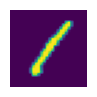

In [20]:
xx = train.loc[0][1:].values.reshape(-1, 28).astype(np.uint8)
xx.shape
show_image(xx);

Let's write the same as a transform that can run on all the datapoints.

In [21]:
class Convert_to_image(Transform):
    def encodes(self, x):
        mat = x[1:].reshape(-1, 28).astype(np.uint8)
        return PILImage.create(mat)

In our case, we don't need to maintain any inner state, hence the `setups` method was skipped. Also there's no need to revert to the original array state (although one can) and therefore the `decodes` method too was skipped.

Let's test this by taking a sample row from our training dataset.

In [22]:
row = train.values[10]
row.shape

(785,)

In [23]:
c2i = Convert_to_image()
c2i(row)

Yay! Now we have an image. Let's also extract the label out of the same data, which is the first value in the array...

In [24]:
class Extract_label(Transform):
    def encodes(self, x):
        return x[0]

In [25]:
el = Extract_label()
el(row)

8

Sweet! 

## Pipelines

Now in order to construct our dataloaders, we still need to run a few more transformations on our independent & dependent variables such as converting the data to a tensor to take advantage of GPU etc. `Pipeline` helps us build a list of transformations to run on our data sequentially. Let's compose two pipelines: one that acts on our dependent data (i.e., images) and another on our independent data (i.e., labels).

In [26]:
x_pipe = Pipeline([Convert_to_image, ToTensor])
y_pipe = Pipeline([Extract_label, Categorize(vocab=train.label.unique())])

For our dependent data, first `Convert_to_image` was run, which takes a row from the dataframe, extract our pixel array, reshapes, converts that to a matrix and then to an image. Later it was converted to a tensor with a `ToTensor` built-in transformation.

For our independent data, the label was first extracted as defined in the `Extract_label` transform above and later converted to a _Category_ that we want to predict using `Categorize` built-in transformation. The total possible labels that can be predicted was passed to the `vocab` (stands for _vocabulary_) parameter.

Now let's run the pipeline to see what we get!

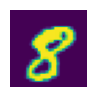

In [27]:
show_image(x_pipe(row));

In [28]:
y_pipe(row)

TensorCategory(8)

Nice! We're now ready to construct our dataloaders.

## Custom Datasets & DataLoaders

To construct dataloaders, a `Datasets` object needs to be created which takes raw data and can apply multiple pipelines in parallel. This wil be used to run our independent & dependent data piplines together. Optionally the parameter `splits` can be specified using one of the `Splitter` transforms, in this case a `RandomSplitter` which returns training & validation indices extracted from our raw dataset.

As we see, most of the functions that're used regularly in fastai are actually transformations itself. :)

In [29]:
splits = RandomSplitter(valid_pct=.2)(np.arange(train.shape[0]))

In [30]:
dsets = Datasets(train.values, [x_pipe, y_pipe], splits=splits)

with the `Datasets` object now obtained, we construct `DataLoaders` object by simply calling `.dataloaders` on it. Since we are not collecting data from disk, we don't have to specify the `path` and can optionally set a *batch_size* with `bs`. As these are just `28x28` images, we can set a bigger batch size.

In [31]:
dls = dsets.dataloaders(bs=512)

In [32]:
len(dls.train.items), len(dls.valid.items)

(33600, 8400)

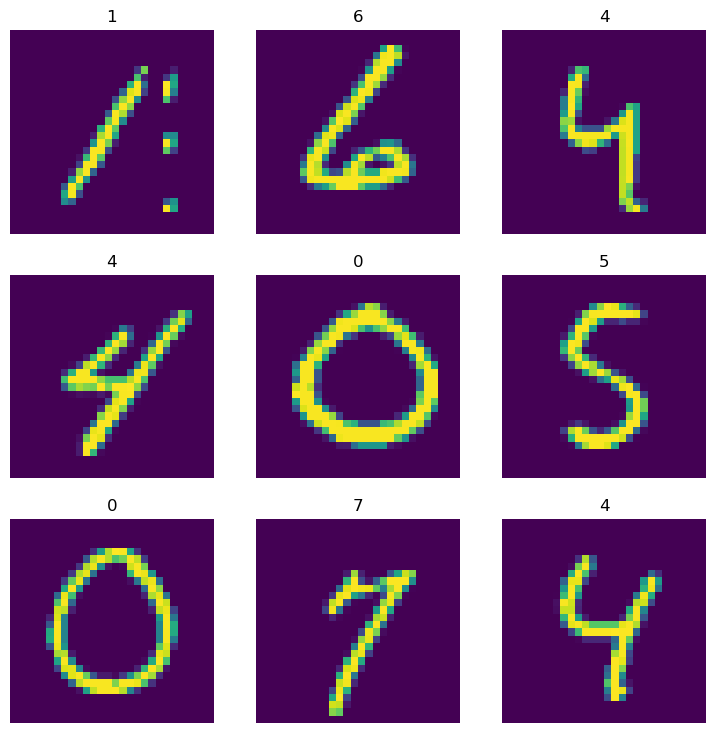

In [33]:
dls.train.show_batch()

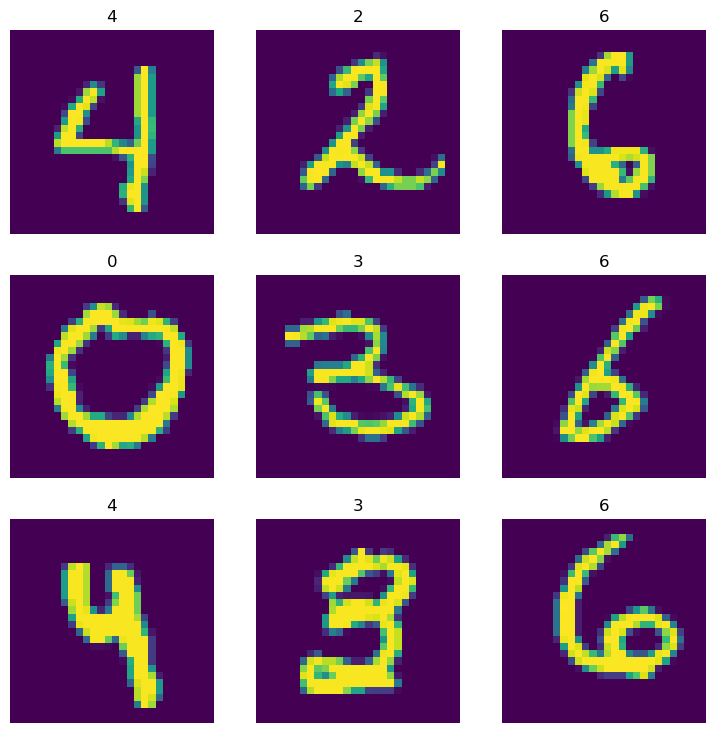

In [34]:
dls.valid.show_batch()

Finally! We have come a long way extracting the raw data from a dataframe to be able to construct a dataloaders object with image as our dependent datablock and category as our indenpendent datablock!

## Train

You can now use this data to train using fastai's `vision_learner` method!

In [35]:
import warnings
warnings.filterwarnings('ignore')

In [36]:
learner = vision_learner(dls, resnet18, metrics=accuracy).to_fp16()

SuggestedLRs(valley=0.0020892962347716093)

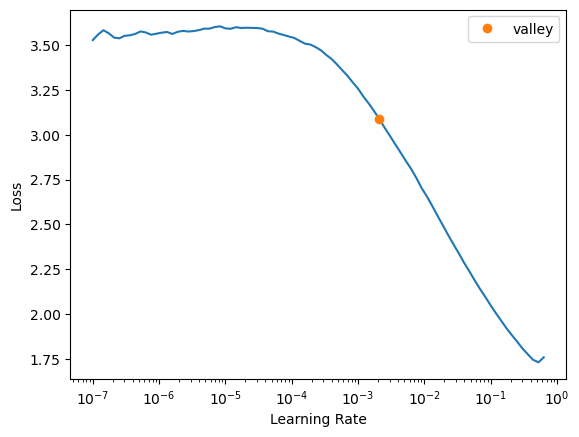

In [37]:
learner.lr_find()

In [38]:
learner.fine_tune(5, 5e-2)

a near 100% accuracy on the validation set ðŸŽ‰

In [39]:
interp = ClassificationInterpretation.from_learner(learner)

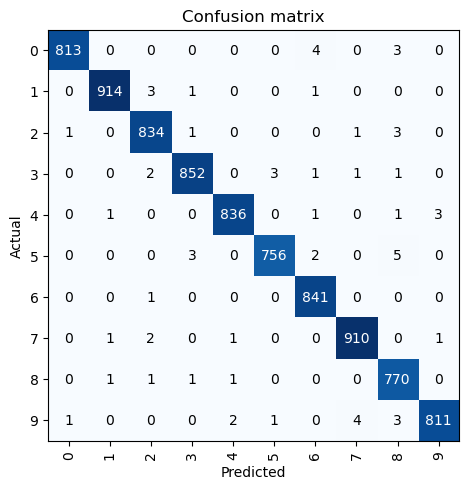

In [40]:
interp.plot_confusion_matrix()

That's it for today! Fastai's mid-level API offers much more functionality and we barely scratched the surface. Hope it inspires you to learn further and take advantage of this powerful feature. Head to the [docs](https://docs.fast.ai) to learn more. Thanks for reading :)